In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
from torch.utils.data import DataLoader, TensorDataset
from torchdiffeq import odeint
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

In [67]:
REG_LAMBDA = 1000.0

In [68]:
# generate s curve data
n_samples = 2000
X_np, t = make_s_curve(n_samples=n_samples, noise=0.0)
X_np = X_np[:, [0, 2]]
X_np = (X_np - X_np.mean(0)) / X_np.std(0)

# add noise
X_np = X_np + np.random.normal(loc=0.0, scale=1.0, size=X_np.shape) * 0.1

# define source and target distributions
source_mask = (t > np.percentile(t, 45)) & (t < np.percentile(t, 55))
target_0_mask = t < np.percentile(t, 10)
target_1_mask = t > np.percentile(t, 90)

# compute geodesic distances
connectivity = kneighbors_graph(X_np, n_neighbors=15, mode='distance', include_self=False)
dist_geodesic = shortest_path(connectivity, directed=False)
max_dist = dist_geodesic[np.isfinite(dist_geodesic)].max()
dist_geodesic[~np.isfinite(dist_geodesic)] = max_dist * 1.1
dist_geodesic = (dist_geodesic + dist_geodesic.T) / 2.0
target_dist_matrix = torch.FloatTensor(dist_geodesic)

# create dataloaded for autoencoder
dataset_ae = TensorDataset(torch.FloatTensor(X_np), torch.arange(n_samples))
loader_ae = DataLoader(dataset_ae, batch_size=256, shuffle=True)

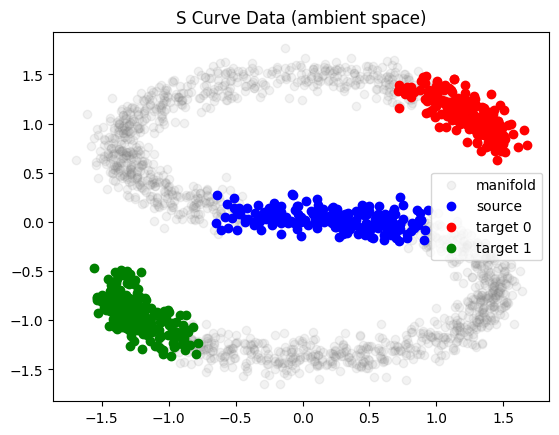

In [71]:
fig = plt.figure()

plt.scatter(X_np[:,0], X_np[:,1], c='gray', alpha=0.1, label='manifold')
plt.scatter(X_np[source_mask,0], X_np[source_mask,1], c='blue', label='source')
plt.scatter(X_np[target_0_mask,0], X_np[target_0_mask,1], c='red', label='target 0')
plt.scatter(X_np[target_1_mask,0], X_np[target_1_mask,1], c='green', label='target 1')
plt.legend()

plt.title("S Curve Data (ambient space)")

plt.show()

In [37]:
# autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

In [ ]:
# train ae
def train_regularized_ae(reg_lambda: float = 0.5):

    model = Autoencoder()

    loss_func = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(500):
        epoch_recon_losses = []
        epoch_geo_losses = []
        for x_batch, indices in loader_ae:
            optimizer.zero_grad()
            z = model.encoder(x_batch)
            x_hat = model.decoder(z)
            latent_dists = torch.cdist(z, z, p=2)
            idx_i, idx_j = torch.meshgrid(indices, indices, indexing='ij')
            target_dists = target_dist_matrix[idx_i, idx_j]

            recon_loss = loss_func(x_hat, x_batch)
            geo_loss = loss_func(latent_dists, target_dists)
            loss = recon_loss + reg_lambda * geo_loss
            loss.backward()
            optimizer.step()

            epoch_recon_losses.append(recon_loss.item())
            epoch_geo_losses.append(geo_loss.item())
        
        if (epoch) % 10 == 0:
            print(f'epoch: {epoch}, recon loss: {np.array(epoch_recon_losses).mean():.2f}, geo loss: {np.array(epoch_geo_losses).mean():.2f}')

    return model

model_ae = train_regularized_ae(reg_lambda=REG_LAMBDA)

epoch: 0, recon loss: 0.59, geo loss: 8.45
epoch: 10, recon loss: 0.00, geo loss: 0.56
epoch: 20, recon loss: 0.01, geo loss: 0.31
epoch: 30, recon loss: 0.01, geo loss: 0.25
epoch: 40, recon loss: 0.01, geo loss: 0.19
epoch: 50, recon loss: 0.01, geo loss: 0.14
epoch: 60, recon loss: 0.01, geo loss: 0.11
epoch: 70, recon loss: 0.01, geo loss: 0.09
epoch: 80, recon loss: 0.01, geo loss: 0.08
epoch: 90, recon loss: 0.01, geo loss: 0.06
epoch: 100, recon loss: 0.01, geo loss: 0.05
epoch: 110, recon loss: 0.01, geo loss: 0.04
epoch: 120, recon loss: 0.01, geo loss: 0.03
epoch: 130, recon loss: 0.01, geo loss: 0.02
epoch: 140, recon loss: 0.01, geo loss: 0.02
epoch: 150, recon loss: 0.01, geo loss: 0.02
epoch: 160, recon loss: 0.01, geo loss: 0.01
epoch: 170, recon loss: 0.00, geo loss: 0.01
epoch: 180, recon loss: 0.01, geo loss: 0.01
epoch: 190, recon loss: 0.00, geo loss: 0.01
epoch: 200, recon loss: 0.01, geo loss: 0.01
epoch: 210, recon loss: 0.00, geo loss: 0.01
epoch: 220, recon los

In [59]:
class NeuralODE(nn.Module):
    def __init__(self, dim=2, cond_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1 + cond_dim, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, dim)
        )

    def forward(self, t, x, c):
        if len(t.shape) == 1:
            t = t.unsqueeze(1)
        if t.shape[0] != x.shape[0]:
            t = t.repeat(x.shape[0], 1)
        return self.net(torch.cat([t, x, c], dim=-1))

In [60]:
# extract latent data
with torch.no_grad():
    Z_all = model_ae.encoder(torch.FloatTensor(X_np))
    Z_source = Z_all[source_mask]
    Z_target_0 = Z_all[target_0_mask]
    Z_target_1 = Z_all[target_1_mask]

n_pairs_per_cond = min(len(Z_source)//2, len(Z_target_0), len(Z_target_1))

# create training pairs
z0_cond0 = Z_source[:n_pairs_per_cond]
z1_cond0 = Z_target_0[:n_pairs_per_cond]

cond0 = torch.zeros(n_pairs_per_cond, 1)
z0_cond1 = Z_source[n_pairs_per_cond:2*n_pairs_per_cond]
z1_cond1 = Z_target_1[:n_pairs_per_cond]
cond1 = torch.ones(n_pairs_per_cond, 1)

fm_source = torch.cat([z0_cond0, z0_cond1], dim=0)
fm_target = torch.cat([z1_cond0, z1_cond1], dim=0)
fm_cond = torch.cat([cond0, cond1], dim=0)

# create datasets
dataset_fm = TensorDataset(fm_source, fm_target, fm_cond)
loader_fm = DataLoader(dataset_fm, batch_size=64, shuffle=True)

In [61]:
# train flow matching model
def train_flow_matching():
    
    print('training flow matching')

    model_fm = NeuralODE(dim=2, cond_dim=1)
    optimizer = optim.Adam(model_fm.parameters(), lr=1e-3)
    
    for epoch in range(1000):
        for z0, z1, c in loader_fm:
            optimizer.zero_grad()
            
            t = torch.rand(z0.shape[0], 1)
            
            z_t = (1 - t) * z0 + t * z1
            u_t = z1 - z0
            
            v_pred = model_fm(t, z_t, c)
            loss = nn.MSELoss()(v_pred, u_t)
            loss.backward()
            optimizer.step()

        if (epoch) % 10 == 0:
            print(f'epoch: {epoch}')

    return model_fm

model_fm = train_flow_matching()

training flow matching
epoch: 0
epoch: 10
epoch: 20
epoch: 30
epoch: 40
epoch: 50
epoch: 60
epoch: 70
epoch: 80
epoch: 90
epoch: 100
epoch: 110
epoch: 120
epoch: 130
epoch: 140
epoch: 150
epoch: 160
epoch: 170
epoch: 180
epoch: 190
epoch: 200
epoch: 210
epoch: 220
epoch: 230
epoch: 240
epoch: 250
epoch: 260
epoch: 270
epoch: 280
epoch: 290
epoch: 300
epoch: 310
epoch: 320
epoch: 330
epoch: 340
epoch: 350
epoch: 360
epoch: 370
epoch: 380
epoch: 390
epoch: 400
epoch: 410
epoch: 420
epoch: 430
epoch: 440
epoch: 450
epoch: 460
epoch: 470
epoch: 480
epoch: 490
epoch: 500
epoch: 510
epoch: 520
epoch: 530
epoch: 540
epoch: 550
epoch: 560
epoch: 570
epoch: 580
epoch: 590
epoch: 600
epoch: 610
epoch: 620
epoch: 630
epoch: 640
epoch: 650
epoch: 660
epoch: 670
epoch: 680
epoch: 690
epoch: 700
epoch: 710
epoch: 720
epoch: 730
epoch: 740
epoch: 750
epoch: 760
epoch: 770
epoch: 780
epoch: 790
epoch: 800
epoch: 810
epoch: 820
epoch: 830
epoch: 840
epoch: 850
epoch: 860
epoch: 870
epoch: 880
epoch: 89

In [62]:
class ODEFunc(nn.Module):
    def __init__(self, vf, condition):
        super().__init__()
        self.vf = vf
        self.condition = condition

    def forward(self, t, z):
        batch_size = z.shape[0]
        cond_batch = self.condition * torch.ones(batch_size, 1)
        t_batch = t * torch.ones(batch_size, 1).to(z.device)
        return self.vf(t_batch, z, cond_batch)

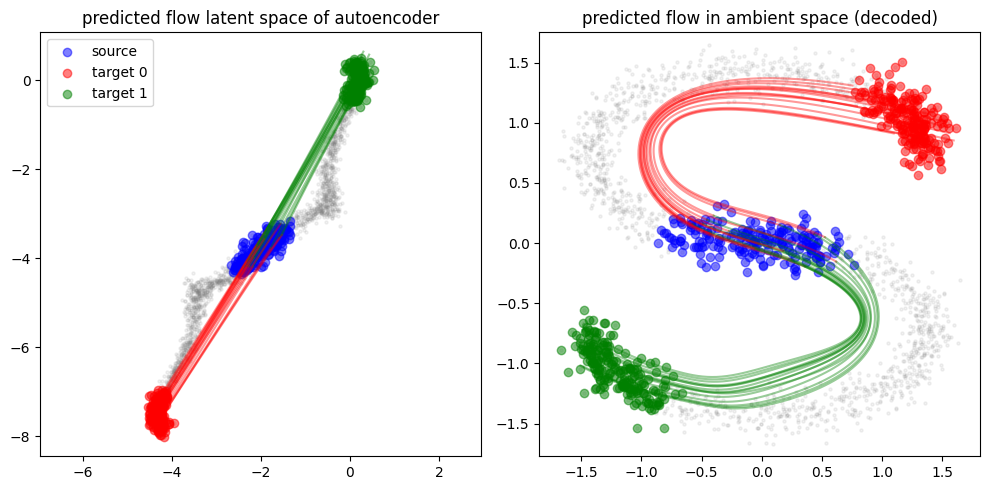

In [63]:
t_span = torch.linspace(0, 1, 100)

test_z0 = Z_source[:15]

ode_func_0 = ODEFunc(model_fm, condition=0.0)
with torch.no_grad():
    z_traj_0 = odeint(ode_func_0, test_z0, t_span, method='dopri5')

ode_func_1 = ODEFunc(model_fm, condition=1.0)
with torch.no_grad():
    z_traj_1 = odeint(ode_func_1, test_z0, t_span, method='dopri5')

def decode_traj(traj):
    T, B, D = traj.shape
    z_traj_flat = traj.view(-1, D)
    with torch.no_grad():
        x_traj_flat = model_ae.decoder(z_traj_flat)
    x_traj = x_traj_flat.view(T, B, -1).numpy()
    return x_traj

x_traj_0 = decode_traj(z_traj_0)
x_traj_1 = decode_traj(z_traj_1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Z_all[:,0], Z_all[:,1], c='gray', alpha=0.1, s=5)
ax[0].scatter(Z_source[:,0], Z_source[:,1], c='blue', alpha=0.5, label='source')
ax[0].scatter(Z_target_0[:,0], Z_target_0[:,1], c='red', alpha=0.5, label='target 0')
ax[0].scatter(Z_target_1[:,0], Z_target_1[:,1], c='green', alpha=0.5, label='target 1')

# plot trajectories
for i in range(len(test_z0)):
    ax[0].plot(z_traj_0[:,i,0], z_traj_0[:,i,1], c='red', alpha=0.4, linewidth=1.5)
    ax[0].plot(z_traj_1[:,i,0], z_traj_1[:,i,1], c='green', alpha=0.4, linewidth=1.5)

ax[0].set_title("predicted flow latent space of autoencoder")
ax[0].legend()
ax[0].axis('equal')

# plot ambient space
ax[1].scatter(X_np[:,0], X_np[:,1], c='gray', alpha=0.1, s=5)
ax[1].scatter(X_np[source_mask,0], X_np[source_mask,1], c='blue', alpha=0.5, label='source')
ax[1].scatter(X_np[target_0_mask,0], X_np[target_0_mask,1], c='red', alpha=0.5, label='target 0')
ax[1].scatter(X_np[target_1_mask,0], X_np[target_1_mask,1], c='green', alpha=0.5, label='target 0')

for i in range(len(test_z0)):
    ax[1].plot(x_traj_0[:,i,0], x_traj_0[:,i,1], c='red', alpha=0.4, linewidth=1.5)
    ax[1].plot(x_traj_1[:,i,0], x_traj_1[:,i,1], c='green', alpha=0.4, linewidth=1.5)

ax[1].set_title("predicted flow in ambient space (decoded)")
ax[1].axis('equal')

plt.tight_layout()
plt.show()

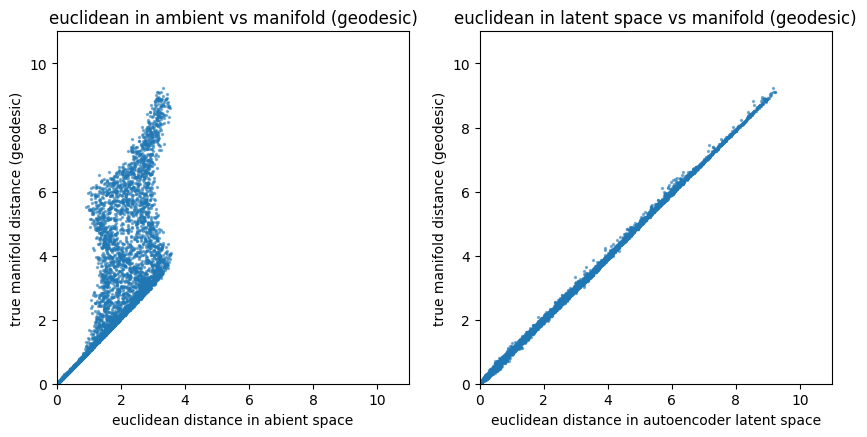

In [64]:
dist_euclidean = pdist(X_np)
dist_latent = pdist(Z_all)
dist_geodesic_flat = squareform(dist_geodesic)

idx = np.random.choice(len(dist_euclidean), 5000, replace=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(dist_euclidean[idx], dist_geodesic_flat[idx], s=2, alpha=0.5)
ax[0].set_xlim(0, 11)
ax[0].set_ylim(0, 11)
ax[0].set_title("euclidean in ambient vs manifold (geodesic)")
ax[0].set_xlabel("euclidean distance in abient space")
ax[0].set_ylabel("true manifold distance (geodesic)")
ax[0].set_aspect('equal', adjustable='box')

ax[1].scatter(dist_latent[idx], dist_geodesic_flat[idx], s=2, alpha=0.5)
ax[1].set_title("euclidean in latent space vs manifold (geodesic)")
ax[1].set_xlabel("euclidean distance in autoencoder latent space")
ax[1].set_ylabel("true manifold distance (geodesic)")
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_xlim(0, 11)
ax[1].set_ylim(0, 11)

plt.show()